In [348]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [350]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [355]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 120, 80, 3),
 '/home/beans/blender_membank/dataloader_06/run_0')

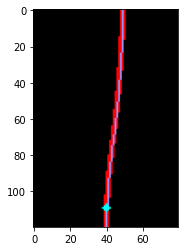

In [356]:
plt.imshow(maps[550])

In [357]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

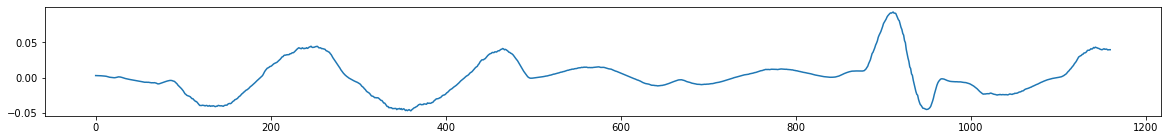

In [358]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

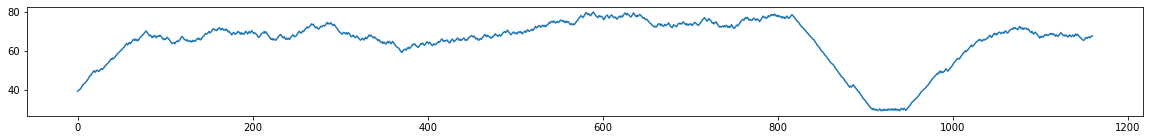

In [359]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [360]:
ix = 1000

In [361]:
t = smooth_near_wps(targets[ix])

In [362]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [363]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

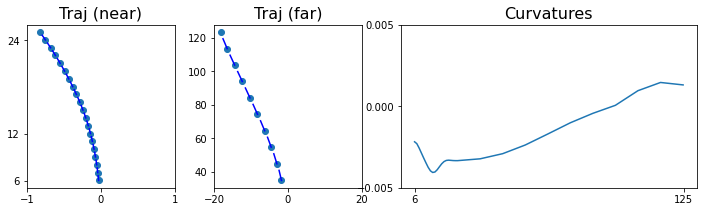

In [364]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

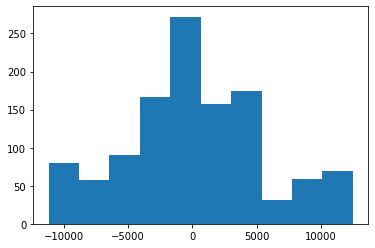

In [365]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

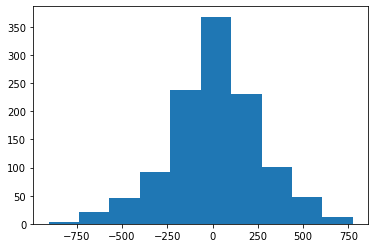

In [366]:
plt.hist(torque[1:]-torque[:-1])[2]

In [367]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [368]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-MAP_WIDTH:,:] = maps[i]
    
    video.write(img)
    
video.release()

In [310]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-MAP_WIDTH:,:] = maps[i]

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "9.24_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 15, 80) (1160, 1, 15, 80)
240 690 3
Made vid!


In [19]:
#combine_vids("8.9_avg", "8.9_avgTrain", "sim")

In [22]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [20]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 179.,  417.,  706., 2015.,  961.,  553.,  718.,  156.,   59.,
          36.]),
 array([-0.0455819 , -0.0341057 , -0.02262951, -0.01115332,  0.00032287,
         0.01179907,  0.02327526,  0.03475145,  0.04622764,  0.05770383,
         0.06918003], dtype=float32),
 <BarContainer object of 10 artists>)

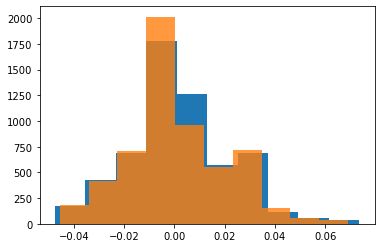

In [21]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

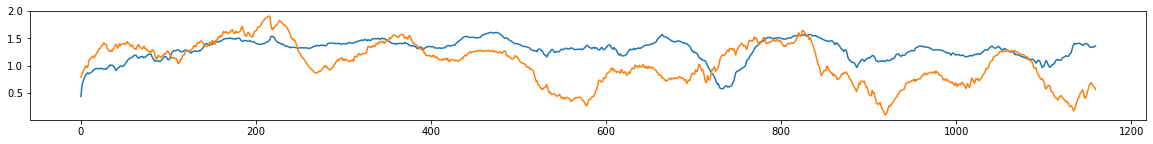

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)

In [369]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [370]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 6.79 s, sys: 2.28 ms, total: 6.79 s
Wall time: 6.8 s


In [371]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [372]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((348, 1160, 30), (348, 1160, 30), (348, 1160, 30), (348, 1160, 30))

In [373]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .05:
        print(i, m)
        mm += 1

60 0.083159804
207 0.057069182
208 0.08286084
345 0.07717655


In [374]:
all_run_paths[337]

'/home/beans/blender_membank/dataloader_11/run_19'

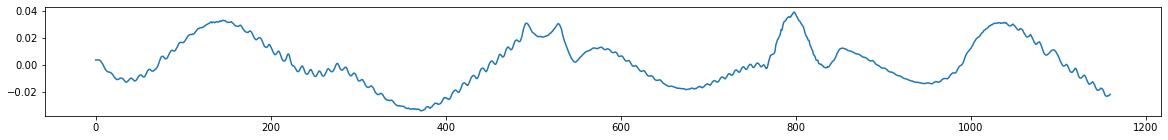

In [375]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[337,:,0])

<BarContainer object of 40 artists>

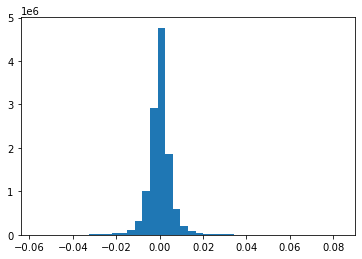

In [376]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [377]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

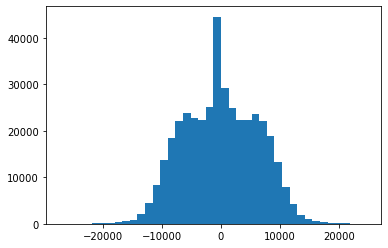

In [378]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

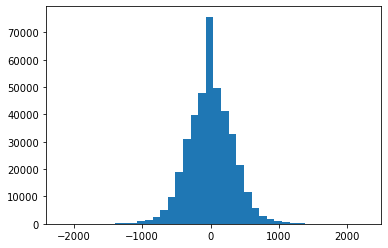

In [379]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [380]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1368.6553046083536, 20288.398702420025)

In [381]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  6.0009427,   7.000974 ,   8.000957 ,   9.000881 ,  10.000743 ,
        11.000515 ,  12.000222 ,  12.999812 ,  13.999323 ,  14.998717 ,
        15.998012 ,  16.997147 ,  17.99621  ,  18.995121 ,  19.993898 ,
        20.992516 ,  21.991018 ,  22.989365 ,  23.987513 ,  24.985538 ,
        34.956383 ,  44.90852  ,  54.841164 ,  64.75457  ,  74.64935  ,
        84.52628  ,  94.386536 , 104.23171  , 114.063095 , 123.882355 ],
      dtype=float32)

<BarContainer object of 40 artists>

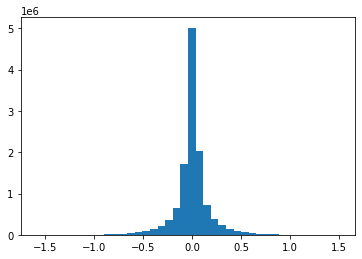

In [382]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [383]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02335343, 0.02707652, 0.03064804, 0.03422152, 0.03779126,
       0.04135282, 0.0449022 , 0.04843709, 0.05195574, 0.05545514,
       0.0589343 , 0.06239236, 0.06582738, 0.06923743, 0.07262069,
       0.07597623, 0.07930264, 0.08259945, 0.08586447, 0.08898775,
       0.11831466, 0.14507465, 0.16820103, 0.18776274, 0.2040111 ,
       0.21736006, 0.22810301, 0.23651636, 0.24289161, 0.24631707],
      dtype=float32)

In [384]:
mean_headings[-1] / mean_headings[0]

10.54736

In [385]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01148868, 0.0134479 , 0.01536471, 0.01725047, 0.01911299,
       0.02095733, 0.02278695, 0.0246041 , 0.02641048, 0.02820629,
       0.02999201, 0.03176802, 0.03353423, 0.03529055, 0.03703722,
       0.03877386, 0.04050039, 0.0422162 , 0.04392145, 0.04561593,
       0.06191638, 0.07689945, 0.09050714, 0.10274357, 0.11360581,
       0.12315546, 0.13149156, 0.13872696, 0.14496742, 0.15030387],
      dtype=float32)

In [386]:
mean_angles[-1] / mean_angles[0]

13.082778

In [387]:
mean_angles[0] / .015

0.7659121106068294

<BarContainer object of 40 artists>

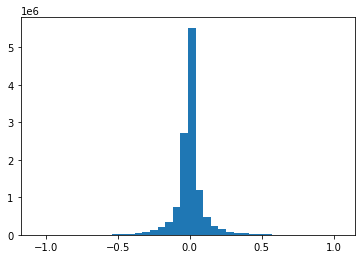

In [388]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

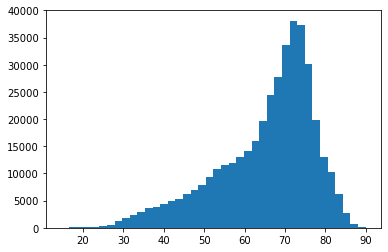

In [389]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

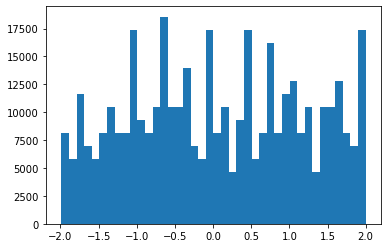

In [390]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

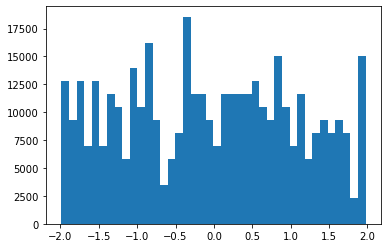

In [391]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]